In [1]:
import pandas as pd
import networkx as nx
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression


/Users/stathis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/stathis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
train_path = 'Data/lucas0_text/lucas0_train.data'
test_path = 'Data/lucas0_text/lucas0_test.data'
targets_path = 'Data/lucas0_text/lucas0_train.targets'
param_path = 'Data/lucas0_text/lucas0.param'


column_names_targets = ['LC']  
column_names = [
    'SMOK',
    'YF',
    'ANX',
    'PP',
    'GEN',
    'ATDSD',
    'BED',
    'CAR',
    'FTG',
    'ALG',
    'COUGH'
]



train = pd.read_csv(train_path, names= column_names,delimiter='\s+')
test = pd.read_csv(test_path)
targets = pd.read_csv(targets_path, names=column_names_targets)
param = pd.read_csv(param_path)

data = pd.concat([train, targets], axis=1)

num_samples = data.shape[0]

# change LC variable from (-1,1) t0 (0,1) for calculations
data['LC'] =data['LC'].replace(-1, 0)

In [3]:
data

,SMOK,YF,ANX,PP,GEN,ATDSD,BED,CAR,FTG,ALG,COUGH,LC
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


## Draw Graph

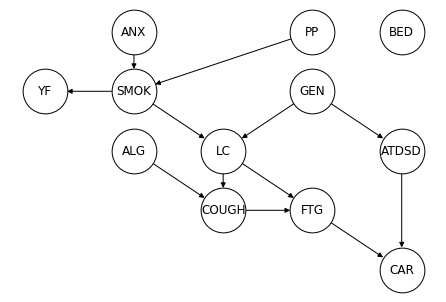

In [56]:
G = nx.DiGraph()

G.add_nodes_from(['ANX', 'PP', 'BED', 'YF', 'SMOK', 'GEN', 'ALG', 'LC', 'ATDSD', 'COUGH', 'FTG', 'CAR'])

G.add_edges_from([('ANX', 'SMOK'),
                   ('PP', 'SMOK'),
                   ('SMOK', 'YF'),
                   ('SMOK', 'LC'),
                   ('COUGH', 'FTG'),
                   ('GEN', 'LC'),
                   ('GEN', 'ATDSD'),
                   ('LC', 'FTG'),
                   ('LC', 'COUGH'),
                   ('FTG', 'CAR'),
                   ('ALG', 'COUGH'),
                   ('ATDSD', 'CAR')])

pos = {'ANX': (-1, 1), 'PP': (1, 1),
       'BED': (2, 1), 'YF': (-2, 0), 'GEN': (1, 0),
       'SMOK': (-1, 0), 'LC': (0, -1), 'COUGH': (0, -2),
       'FTG': (1, -2), 'CAR': (2, -3), 'ALG': (-1, -1), 'ATDSD': (2, -1)}

nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='w', edgecolors='black')
nx.write_gml(G, "lung_cancer_graph.gml")

In [57]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display


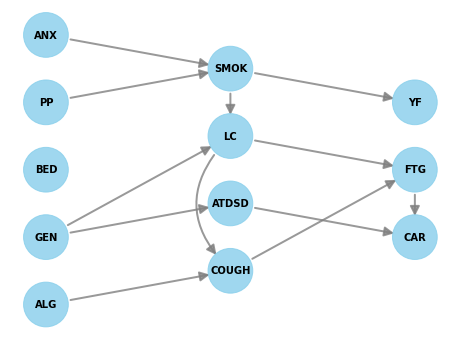

In [60]:
from IPython.display import Image, display

gml_graph = gml_to_string('lung_cancer_graph.gml')
# With GML string
model=CausalModel(
    data = data,
    treatment='COUGH',
    outcome='FTG',
    graph=gml_graph
)
model.view_model()

# ATE of Coughing on Fatigue

## 1. Find adj sets

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢  d         ⎛  d            ⎞  ⎥
E⎢──────(FTG)⋅⎜──────([COUGH])⎟  ⎥
 ⎣d[ALG]      ⎝d[ALG]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→FTG then ¬(U →→{ALG})
Estimand assumption 2, Exclusion: If we remove {ALG}→{COUGH}, then ¬({ALG}→FTG)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Found Lung Cuncer as adj set with backdoor 

## 2. Make biased linear estimation

In [63]:

v0_vals = data['COUGH'].values.reshape(num_samples, 1)
y_vals = data['FTG'].values.reshape(num_samples, 1)

In [64]:
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[0.44200005]])

## Make unbiased linear estimation using backdoot adj set

In [65]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.3532092786978183

Causal Estimate is 0.3532092786978183


/Users/stathis/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Make unbiased inverse propensity weighting using backdoot adj set

In [73]:
t_group = data[data["COUGH"]==1]
c_group = data[data["COUGH"]==0]

In [74]:
treatment_group_LC_0 = t_group[t_group["LC"]==0]
treatment_group_LC_1 = t_group[t_group["LC"]==1]

control_group_LC_0 = c_group[c_group["LC"]==0]
control_group_LC_1 = c_group[c_group["LC"]==1]

In [75]:
LC_0_group = pd.concat([treatment_group_LC_0,control_group_LC_0])
LC_1_group = pd.concat([treatment_group_LC_1,control_group_LC_1])


In [76]:
LC_1_group

,SMOK,YF,ANX,PP,GEN,ATDSD,BED,CAR,FTG,ALG,COUGH,LC
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
5,1,1,0,1,0,0,1,1,1,1,1,1
6,1,1,1,1,0,0,0,1,1,0,1,1
7,1,1,1,0,0,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1,1,1,0,1,1,1,1,0,0,0,1
1953,1,1,1,0,0,0,1,1,1,0,0,1
1954,1,1,1,0,0,0,0,0,0,0,0,1
1963,1,1,1,1,0,1,1,1,0,0,0,1


In [77]:
propensity_score_LC_0 = len(treatment_group_LC_0)/len(LC_0_group)
propensity_score_LC_1 = len(treatment_group_LC_1)/len(LC_1_group)

In [78]:
number_of_all_samples = num_samples

weighted_sum_treatment_0 = sum(treatment_group_LC_0["FTG"])/ propensity_score_LC_0
weighted_sum_treatment_1 = sum(treatment_group_LC_1["FTG"])/ propensity_score_LC_1


mean_treatment2 = weighted_sum_treatment_0 + weighted_sum_treatment_1 
mean_treatment2 = mean_treatment2/number_of_all_samples

weighted_sum_control_0 = sum(control_group_LC_0["FTG"])/(1 - propensity_score_LC_0)
weighted_sum_control_1 = sum(control_group_LC_1["FTG"])/ (1 - propensity_score_LC_1)

mean_control2 = weighted_sum_control_0 + weighted_sum_control_1 
mean_control2 = mean_control2/number_of_all_samples

ATE_IPW2 = mean_treatment2-mean_control2
print("ATE after IPW:", ATE_IPW2)

ATE after IPW: 0.3507998093204841


In [79]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.35197519148673784

Causal Estimate is 0.35197519148673784
